# Kernel SHAP explanation for multinomial logistic regression models 

## Introduction

In a previous [example](kernel_shap_wine_intro.ipynb), we showed how the KernelSHAP algorithm can be aplied to explain the output of an arbitrary classification model so long the model outputs probabilities or operates in margin space and showcased some visualisations that can be helpful when working with models. In this example we focus on understanding, in a simple setting, how conclusions drawn from the analysis of the KernelShap output relate to conclusions drawn from interpreting the model directly. To make this possible, we fit a logistic regression model on the Wine dataset.

In [69]:
import shap

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from scipy.special import logit
from sklearn import svm
from sklearn.datasets import load_wine
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
shap.initjs()

## Data preparation: load and split Wine dataset

In [70]:
wine = load_wine()
wine.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [71]:
data = wine.data
target = wine.target
target_names = wine.target_names
feature_names  = wine.feature_names

Split data into testing and training sets and normalize it.

In [72]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    target, 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                   )
print("Training records: {}".format(X_train.shape[0]))
print("Testing records: {}".format(X_test.shape[0]))

Training records: 142
Testing records: 36


In [17]:
scaler = StandardScaler().fit(X_train)
X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

## Fitting a multinomial logistic regression classifier to the Wine dataset

### Training 

In [18]:
classifier = LogisticRegression(multi_class='multinomial',
                                random_state=0,
                                )
classifier.fit(X_train_norm, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Model assessment

Look at at average $10$-fold cross validation accuracy and 

In [19]:
y_pred = classifier.predict(X_test_norm)

In [20]:
cm = confusion_matrix(y_test, y_pred)

In [21]:
accuracies = cross_val_score(estimator = classifier, 
                             X = X_train_norm,
                             y = y_train, 
                             cv = 10,
                            )
print("10-fold average accuracy:", accuracies.mean())

10-fold average accuracy: 0.971904761904762


Text(0.5, 1.0, 'Confusion matrix for the logistic regression classifier')

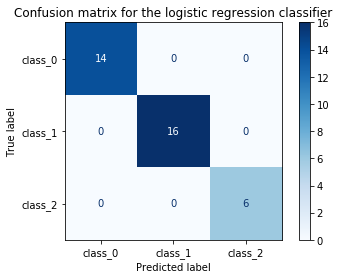

In [22]:
title = 'Confusion matrix for the logistic regression classifier'
disp = plot_confusion_matrix(classifier, 
                             X_test_norm, 
                             y_test,
                             display_labels=target_names,
                             cmap=plt.cm.Blues,
                             normalize=None,
                            )
disp.ax_.set_title(title)

## Intepreting the logistic regression model

<a id='src_2'></a>
One way to arrive at the multinomial logistic regression model is to consider the $k$ binary problems where a linear predictor function $f(k, i)$ is used to model the the outcome $p(y=k|x, \mathbf{\beta}) = \text{Cat} (y| \mathbf{\beta} x)$ where $\beta$ is $n_{class} \times D$ where $D$ is the feature dimensionality. Because modelling the outcome bounded by $[0, 1]$ is difficult, a *logit link* function $g : [0, 1] \to \mathbb{R}, g(p) = \log \left( \frac{p}{1-p} \right)$ is used to convert the probability levels of the categorical response to an ubounded domain. A linear predictor function 
<h3 align="center"> $f(k, i) = \beta_{0,k} + \beta_{1,k} x_{1,i}  + \beta_{2,k} x_{2,i} + \cdots + \beta_{M,k} x_{M,i}$ </h3>

is used to fit the logit transformation, for each class $k$ given a set of training examples $\mathcal{D}=  \{(x_i, y_i)\}_{i=1}^N$. Thus, for each class, the vector of coefficients $\mathbb{\beta}_k$ can be used to interpret the model *globally*; in the absence of interaction terms, the coefficient of a predictor (i.e.,  independent variable) represents the *change in log odds* when the predictor changes by one unit while all other variables are kept at fixed values. Equivalently, the exponentiated coefficient is equivalent to a change in odds. Since the transformation from odds to outcome probabilities is monotonic, a change in odds also implies a change in the outcome probability in the same direction. Thus, the magnitudes of the feature coefficients measure the effect of a predictor on the output and thus one can globally interpret the logistic regression model.

However, the log odds ratios and odds ratios are known to be sensitive to *unobserved heterogenity*, that is, omission of a variable with good explanatory power from a logistic regression model *assumed true*. While we will not be concerned directly with this issue and refer the interested reader to [2](#ref_1), we will be using the *estimated percentage unit effect* (or the *marginal effect*)

<h3 align="center"> $\beta_{j,k} \times p_{i,k}(1 - p_{i, k})$</h3>

as a means of estimating the effect of a predictor $x_j$ on individual $i$ and thus *locally* interpret the model. The average marginal effect (AME) of a predictor

<h3 align="center"> $\frac{1}{n} \sum_{i=1}^{n}\beta_{j,k} \times p_{i,k} (1 - p_{i,k})$</h3>

is equivalent to simply using $\beta_{j,k}$ to *globally* explain the model.

In [50]:
def issorted(arr, reverse=False):
    """
    Checks if a numpy array is sorted.
    """
    
    if reverse:
        return np.all(arr[::-1][:-1] <=arr[::-1][1:])
    
    return np.all(arr[:-1] <= arr[1:])

def extract_importances(class_idx, beta, feature_names, intercepts=None):
    """
    Retrive and sort abs magnitude of coefficients from model.
    """
    
    # sort the absolute value of model coef from largest to smallest
    srt_beta_k = np.argsort(np.abs(beta[class_idx, :]))[::-1]
    feat_names = [feature_names[idx] for idx in srt_beta_k]
    feat_imp = beta[class_idx, srt_beta_k]
    
    # include bias among feat importances 
    if intercepts is not None: 
        intercept = intercepts[class_idx]
        bias_idx = len(feat_imp) - (np.searchsorted(np.abs(feat_imp)[::-1], np.abs(intercept)))
#         bias_idx = np.searchsorted(np.abs(feat_imp)[::-1], np.abs(intercept)) + 1
        feat_imp = np.insert(feat_imp, bias_idx, intercept.item(), )
        intercept_idx = np.where(feat_imp == intercept)[0][0]
        feat_names.insert(intercept_idx, 'bias')

    return feat_imp, feat_names

def plot_importances(feat_imp, feat_names, class_idx, **kwargs):
    """
    Create a horizontal barchart of feature effects, sorted by their magnitude.
    """
    
    left_x, right_x = kwargs.get("left_x"), kwargs.get("right_x")
    eps_factor = kwargs.get("eps_factor", 4.5)
    
    fig, ax = plt.subplots(figsize=(10, 5))
    y_pos = np.arange(len(feat_imp))
    ax.barh(y_pos, feat_imp)
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feat_names, fontsize=15)
    ax.invert_yaxis()                  # labels read top-to-bottom
    ax.set_xlabel('Feature effects for class {}'.format(class_idx), fontsize=15)
    ax.set_xlim(left=left_x, right=right_x)
    
    for i, v in enumerate(feat_imp):
        eps = 0.03
        if v < 0:
            eps = -eps_factor*eps
        ax.text(v + eps, i + .25, str(round(v, 3)))
    
    return ax, fig

We now retrieve the estimate coefficients, and plot them sorted by their maginitude.

In [51]:
beta = classifier.coef_
intercepts = classifier.intercept_
all_coefs = np.concatenate((beta, intercepts[:, None]), axis=1)

In [52]:
class_idx = 0
feat_imp, feat_names = extract_importances(class_idx, 
                                           beta, 
                                           feature_names,
                                           intercepts=intercepts,
                                          )

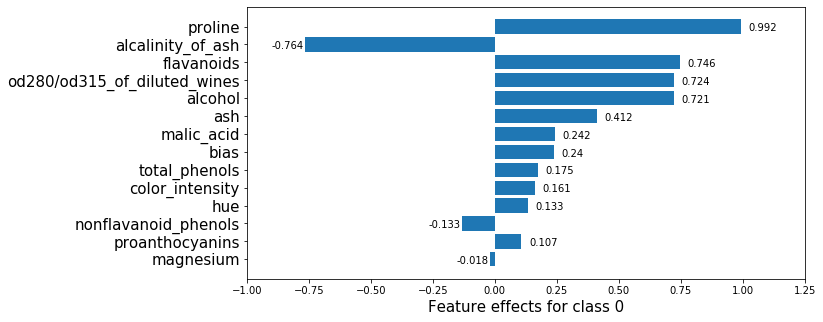

In [53]:
_, class_0_fig = plot_importances(feat_imp, 
                                  feat_names, 
                                  class_idx,
                                  left_x=-1.,
                                  right_x=1.25,
                                  )

In [61]:
classifier.intercept_

array([ 0.24013981,  0.66712652, -0.90726633])

This plot shows that features such as `proline`, `flavanoids`, `od280/od315_of_diluted_wines`, `alcohol` increase the odds of *any* sample being classified as `class_0` whereas the `alcalinity_of_ash` decreases them.

In [15]:
feat_imp, feat_names = extract_importances(1, # class_idx 
                                           beta, 
                                           feature_names,
                                           intercepts=intercepts,
                                          )

The plot below shows that, however, `alcalinity_of_ash` increases the odds of a wine being in `class_1`. Predictors such as `proline`, `alcohol` or `ash`, which increase the odds of predicting a wine as a member of `class_0`, decrease the odds of predicting it as a member of `class_1`.

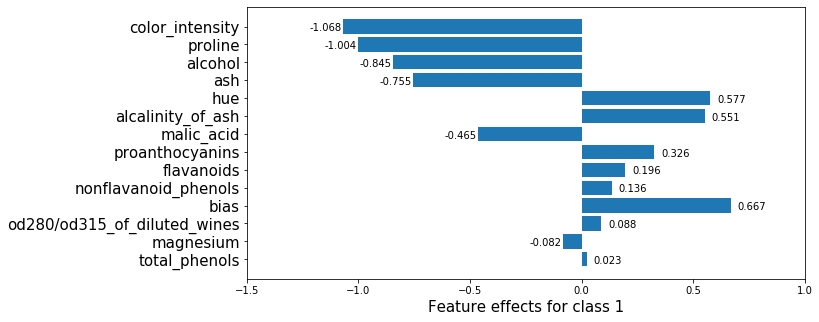

In [16]:
_, class_1_fig = plot_importances(feat_imp, 
                                  feat_names, 
                                  class_idx=1, 
                                  left_x=-1.5,
                                  right_x=1,
                                  eps_factor = 5.  # controls text distance from end of bar for negative examples
                                  )

In [17]:
feat_imp, feat_names = extract_importances(2, # class_idx
                                           beta, 
                                           feature_names,
                                           intercepts=intercepts,
                                          )

Finally, for `class_2`, the `color_intensity`, `ash` are the features that increase the `class_2` odds.

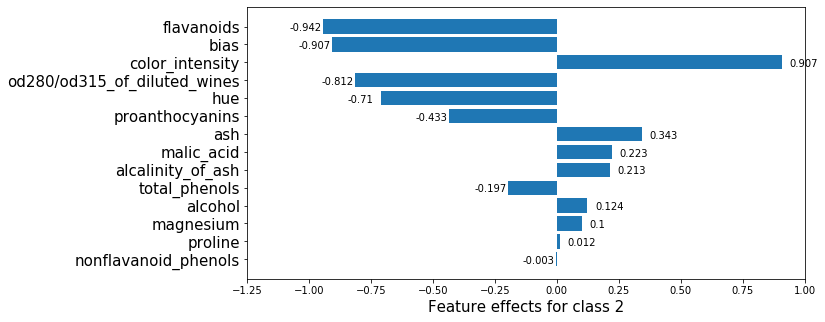

In [18]:
_, class_2_fig = plot_importances(feat_imp, 
                                  feat_names, 
                                  class_idx=2, 
                                  left_x=-1.25,
                                  right_x=1,
#                                   eps_factor = 5.
                                  )

## Apply KernelSHAP to explain the model

<a id='src_1'></a>
Note that the *local accuracy* property of SHAP (eq. (5) in [1](#ref_1))  requires
<h3 align='center'> $f(x) = g(x') = \phi_0 + \sum_{i=1}^M \phi_i x_i'.$</h3>

Hence, sum of the feature importances should be equal to the model output, $f(x)$. By passing `link='logit'` to the explainer, we ensure that $\phi_0$, the *base value* (see _**Local explanation**_ section [here](#kernel_shap_wine_intro.ipynb)) will be calculated in the correct units.

In [19]:
pred_fcn = classifier.predict_proba
lr_explainer = shap.KernelExplainer(pred_fcn, X_train_norm, link='logit')

Using 142 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [20]:
# passing the logit link function to the explainer ensures the units are consistent ...
mean_scores_train = logit(pred_fcn(X_train_norm).mean(axis=0))
print(mean_scores_train - lr_explainer.expected_value)  

[-6.66133815e-16  0.00000000e+00  4.44089210e-16]


In [21]:
lr_shap_values = lr_explainer.shap_values(X_test_norm)

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!
l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_

l1_reg="auto" is deprecated and in the next version (v0.29) the behavior will change from a conditional use of AIC to simply "num_features(10)"!


### Explaining the logitstic regression model globally with KernelSHAP

#### Summary plots

To visualise the impact of the features on the decision scores associated with class `class_idx`, we can use a summary plot. In this plot, the features are sorted by the sum of their SHAP values magnitudes across all instances in `X_test_norm`. Therefore, the features with the highest impact on the decision score for class `class_idx` are displayed at the top of the plot.

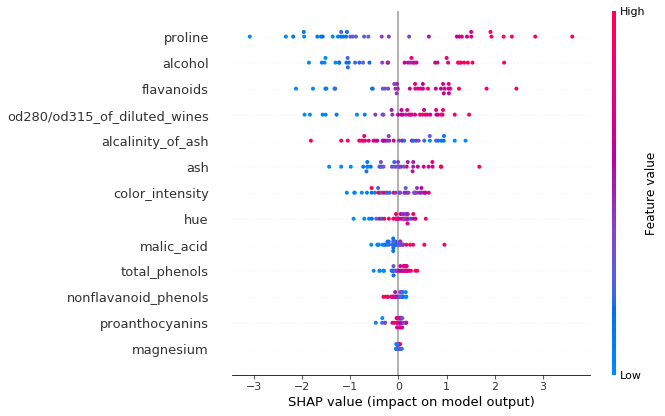

In [22]:
shap.summary_plot(lr_shap_values[class_idx], X_test_norm, feature_names)

Because the logistic regression model uses a linear predictor function, the exact shap values for each class $k$ can be computed exactly according to ([[1]](#ref_1))
<h3 align="center">$ \phi_{i,j}(f, x) = \beta_{j,k}(x_{i,j} - \mathbb{E}_{\mathcal{D}}[x_{j}]).$</h3>

This allows us to check the accuracy of the SHAP estimate. Note that we have already applied the normalisation so the expectation is not subtracted below.


In [23]:
exact_shap = beta[:, None, :]*X_test_norm

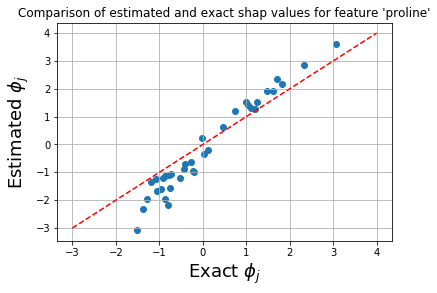

In [24]:
feat_name = 'proline'
feat_idx = feature_names.index(feat_name)
x = np.linspace(-3, 4, 1000)
plt.scatter(exact_shap[class_idx,...][:, feat_idx], lr_shap_values[class_idx][:, feat_idx])
plt.plot(x, x, linestyle='dashed', color='red')
plt.xlabel('Exact $\phi_j$', fontsize=18)
plt.ylabel('Estimated $\phi_j$', fontsize=18)
plt.title(r"Comparison of estimated and exact shap values for feature '{}'".format(feat_name))
plt.grid(True)

The plot below shows that,the exact shap values and the estimate values give rise to similar ranking of the features, and only the order of the `flavanoids` and `alcohol`features is swapped.

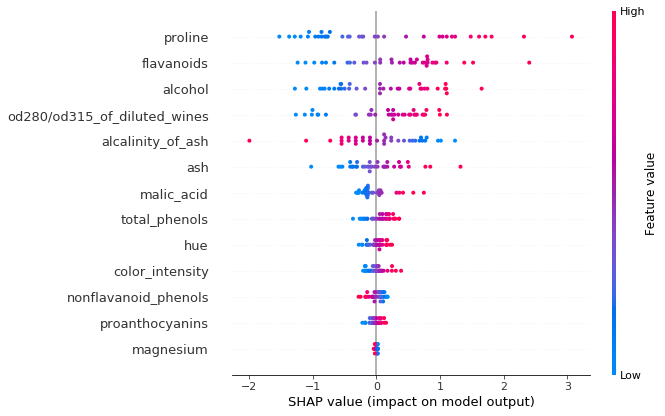

In [25]:
shap.summary_plot(exact_shap[class_idx, ...], X_test_norm, feature_names)

An simlar plot can be create for the logistic regression model by plotting the marginal effects.

In [26]:
p = classifier.predict_proba(X_test_norm)
prb = p * (1. - p) 
marg_effects = all_coefs[:, None, :] * prb.T[..., None]
assert (all_coefs[0, 0] * prb[:, 0] - marg_effects[0, :, 0]).sum() == 0.0
avg_marg_effects = np.mean(marg_effects, axis=1) # nb: ranking of the feature coefs should be preserved

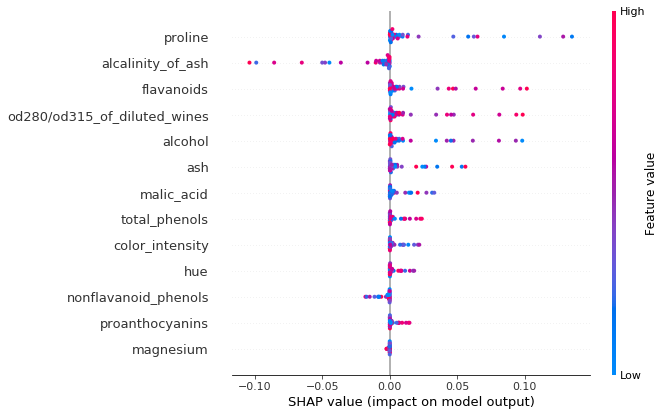

In [27]:
shap.summary_plot(marg_effects[class_idx, :, :-1], X_test_norm, feature_names)  # exclude bias

As expected, the ranking of the marginal effects is the same as that provided the ranking the raw coefficients (see below). However, this effect measure allows us to assess the effects at instance level. Note that while all the marginal effects have the same sign, the inputs are both positive and negative so the percentage unit effects can be both positive and negative, just like the shap values. 

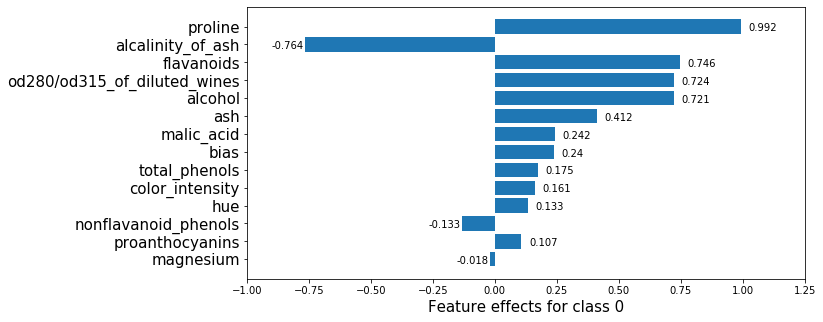

In [28]:
class_0_fig

Looking at the 6 most important features for this classification in `class_0`, we see that both the `KernelSHAP` method and the logistic regression rank the `proline` feature as the one with the most significant effect. While the order of the subsequent 5 features is permuted, the effects of these features are also very similar so, in effect, so similar conclusions would be drawn from analysing either output.

### References

<a id='ref_1'></a>
[1](#src_1) *[1] Lundberg, S.M. and Lee, S.I., 2017. A unified approach to interpreting model predictions. In Advances in neural information processing systems (pp. 4765-4774).*

[2](#src_2) *[2]Mood, C., 2017. "Logistic regression: Uncovering unobserved heterogeneity."*

# TODO

- Look at this and give some explanation about background data https://github.com/slundberg/shap/issues/922